# Creating a Spam Classifier Model with R
## NLP and Naive Bayes

The data used in this model is from the UCI Machine Learning repository (https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

### The sole purpose of this notebook is to rebuild a simplied version of a spam classifier I had built with Python using R.

In [60]:
# Import libraries
library(wordcloud)
library(wordcloud2)
library(RColorBrewer)
library(tm)
library(magrittr)
library(caret)
library(e1071)
library(SnowballC)

In [61]:
# Read in data
df <- read.csv("smsspamcollection/spamham.csv")
table(df$label)
head(df, n = 5)


 ham spam 
4825  747 

,label,text
,<fct>,<fct>
1,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
2,ham,Ok lar... Joking wif u oni...
3,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
4,ham,U dun say so early hor... U c already then say...
5,ham,"Nah I don't think he goes to usf, he lives around here though"


### Data Visualizations with Wordclouds

In [62]:
# Split dataframe by ham and spam
spam_split <- split(df, df$label)
spam <- spam_split$spam
ham <- spam_split$ham

In [63]:
# Create a vector of just spam text data
spam_text <- spam$text

In [64]:
# Create a spam corpus  
spam_docs <- Corpus(VectorSource(spam_text))

In [65]:
# Clean spam text with tm library
spam_docs <- spam_docs %>%
  tm_map(removeNumbers) %>%
  tm_map(removePunctuation) %>%
  tm_map(stripWhitespace)
spam_docs <- tm_map(spam_docs, content_transformer(tolower))
spam_docs <- tm_map(spam_docs, removeWords, stopwords("english"))

Warning message in tm_map.SimpleCorpus(., removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., stripWhitespace):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(spam_docs, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(spam_docs, removeWords, stopwords("english")):
“transformation drops documents”


In [66]:
# Create document spam term matrix
spam_dtm <- TermDocumentMatrix(spam_docs) 
spam_matrix <- as.matrix(spam_dtm)
spam_words <- sort(rowSums(spam_matrix),decreasing=TRUE)
spam_df <- data.frame(word = names(spam_words),freq = spam_words)

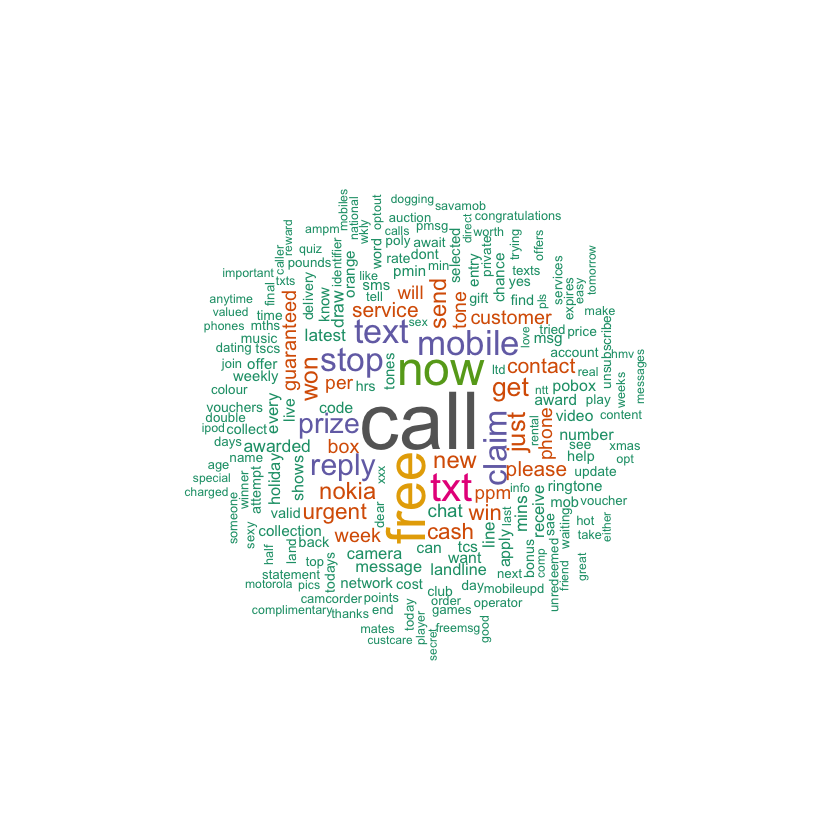

In [67]:
# Create spam wordcloud
wordcloud(words = spam_df$word, freq = spam_df$freq, min.freq = 1,
          max.words = 200, random.order = FALSE, rot.per = 0.35,
          colors = brewer.pal(8, "Dark2"))

In [68]:
# Create a vector of just ham text data
ham_text <- ham$text

In [69]:
# Create a ham corpus  
ham_docs <- Corpus(VectorSource(ham_text))

In [70]:
# Clean ham text with tm library
ham_docs <- ham_docs %>%
  tm_map(removeNumbers) %>%
  tm_map(removePunctuation) %>%
  tm_map(stripWhitespace)
ham_docs <- tm_map(ham_docs, content_transformer(tolower))
ham_docs <- tm_map(ham_docs, removeWords, stopwords("english"))

Warning message in tm_map.SimpleCorpus(., removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., stripWhitespace):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(ham_docs, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(ham_docs, removeWords, stopwords("english")):
“transformation drops documents”


In [71]:
# Create document ham term matrix
ham_dtm <- TermDocumentMatrix(ham_docs) 
ham_matrix <- as.matrix(ham_dtm)
ham_words <- sort(rowSums(ham_matrix),decreasing=TRUE)
ham_df <- data.frame(word = names(ham_words),freq = ham_words)

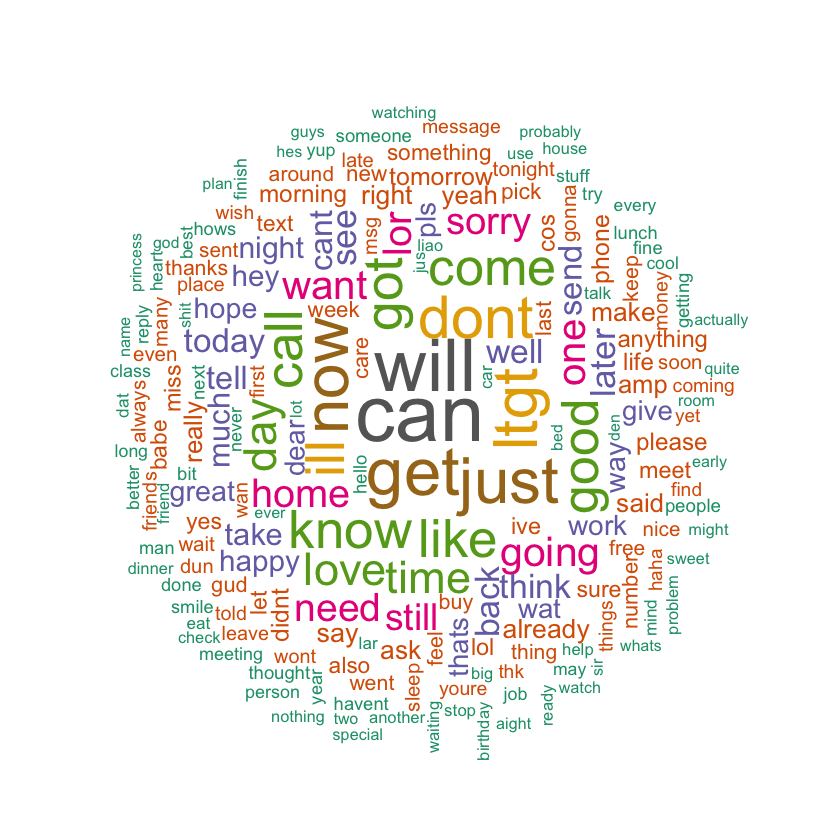

In [72]:
# Create ham wordcloud
wordcloud(words = ham_df$word, freq = ham_df$freq, min.freq = 1,
          max.words = 200, random.order = FALSE, rot.per = 0.35,
          colors = brewer.pal(8, "Dark2"))

### Model Preprocessing

In [73]:
# Create corpus and document term matrix
df_corpus <- VCorpus(VectorSource(df$text))

df_dtm <- DocumentTermMatrix(df_corpus, control = 
                                 list(tolower = TRUE,
                                      removeNumbers = TRUE,
                                      stopwords = TRUE,
                                      removePunctuation = TRUE,
                                      stemming = TRUE))

dim(df_dtm)

[1] 5572 7014

In [74]:
# Calculate train test proportions
index <- floor(5572 * .8)

#Training & Test set
train <- df_dtm[1:index, ]
test <- df_dtm[index:5572, ]

#Training & Test Label
train_labels <- df[1:index, ]$label
test_labels <- df[index:5572, ]$label

#Proportion for training & test labels
prop.table(table(train_labels))
prop.table(table(test_labels))

train_labels
      ham      spam 
0.8649316 0.1350684 

test_labels
      ham      spam 
0.8700717 0.1299283 

In [75]:
# Convert to categorical for naive bayes model
convert_values <- function(x) {
  x <- ifelse(x > 0, "Yes", "No")
}

train <- apply(train, MARGIN = 2, convert_values)
test <- apply(test, MARGIN = 2, convert_values)

### Modeling

In [78]:
#Create model from the training dataset
spam_classifier <- naiveBayes(train, train_labels)

#Make predictions on test set
y_hat_test <- predict(spam_classifier, test)

#Create confusion matrix
confusionMatrix(data = y_hat_test, reference = test_labels,
                positive = "spam", dnn = c("Prediction", "Actual"))

Confusion Matrix and Statistics

          Actual
Prediction ham spam
      ham  962   16
      spam   9  129
                                          
               Accuracy : 0.9776          
                 95% CI : (0.9671, 0.9855)
    No Information Rate : 0.8701          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8988          
                                          
 Mcnemar's Test P-Value : 0.2301          
                                          
            Sensitivity : 0.8897          
            Specificity : 0.9907          
         Pos Pred Value : 0.9348          
         Neg Pred Value : 0.9836          
             Prevalence : 0.1299          
         Detection Rate : 0.1156          
   Detection Prevalence : 0.1237          
      Balanced Accuracy : 0.9402          
                                          
       'Positive' Class : spam            
                              